# **Занятие 2.**

# [Pytorch autograd](https://pytorch.org/docs/stable/autograd.html)

[Tutorial](https://www.youtube.com/watch?v=MswxJw-8PvE)

[Slides](https://app.diagrams.net/#G1bq3akhmA5DGRCiFYJfNPSn7il2wvCkEY)

[Torch C++ Binary operations](https://github.com/pytorch/pytorch/blob/c5872e6d6d8fd9b8439b914c143d49488335f573/aten/src/ATen/native/cpu/BinaryOpsKernel.cpp)

[Torch C++ Activations](https://github.com/pytorch/pytorch/blob/c5872e6d6d8fd9b8439b914c143d49488335f573/aten/src/ATen/native/cpu/Activation.cpp)

In [5]:
import torch

In [6]:
def show_tensor_params(*tensors):
  for x in tensors:
    print('---')
    print(f"data - {x.data}")
    print(f"grad - {x.grad}")
    print(f"grad_fn - {x.grad_fn}")
    print(f"req_grad - {x.requires_grad}")
    print(f"is_leaf - {x.is_leaf}")

In [7]:
x = torch.tensor(5.0)
show_tensor_params(x)

---
data - 5.0
grad - None
grad_fn - None
req_grad - False
is_leaf - True


All Tensors that have **requires_grad** which is **False** will be leaf Tensors by convention.

For Tensors that have **requires_grad** which is **True**, they will be leaf Tensors if they were created by the user. This means that they are not the result of an operation and so **grad_fn** is None.

Only leaf Tensors will have their **grad** populated during a call to backward(). To get grad populated for non-leaf Tensors, you can use retain_grad().[[Link]](https://pytorch.org/docs/stable/generated/torch.Tensor.is_leaf.html#torch.Tensor.is_leaf)

In [8]:
#Slide A4
a = torch.tensor(2.0, requires_grad=True)
b = torch.tensor(3.0)
c = a*b

c.backward()
# (2 * c).backward()

In [9]:
show_tensor_params(a, b, c)

---
data - 2.0
grad - 3.0
grad_fn - None
req_grad - True
is_leaf - True
---
data - 3.0
grad - None
grad_fn - None
req_grad - False
is_leaf - True
---
data - 6.0
grad - None
grad_fn - <MulBackward0 object at 0x7c2f010c38e0>
req_grad - True
is_leaf - False


<ipython-input-6-168b1ceafb31>:5: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  print(f"grad - {x.grad}")


In [ ]:
#Slide Simple5

In [10]:
a = torch.tensor(2.0, requires_grad=True)
b = torch.tensor(3.0, requires_grad=True)
c = a*b
d = torch.tensor(4.0, requires_grad=True)
e = c*d

c.retain_grad()
e.retain_grad()
e.backward()

In [11]:
show_tensor_params(a, b, c, d, e)

---
data - 2.0
grad - 12.0
grad_fn - None
req_grad - True
is_leaf - True
---
data - 3.0
grad - 8.0
grad_fn - None
req_grad - True
is_leaf - True
---
data - 6.0
grad - 4.0
grad_fn - <MulBackward0 object at 0x7c2f010c3b50>
req_grad - True
is_leaf - False
---
data - 4.0
grad - 6.0
grad_fn - None
req_grad - True
is_leaf - True
---
data - 24.0
grad - 1.0
grad_fn - <MulBackward0 object at 0x7c2f010c3520>
req_grad - True
is_leaf - False


In [12]:
#In place 1
a = torch.tensor(2.0, requires_grad=True)
b = torch.tensor(3.0, requires_grad=True)
c = a*b
d = torch.tensor(4.0, requires_grad=True)
e = c*d
c += 1

e.backward()

RuntimeError: ignored

In [13]:
print(c._version)
print(d._version)

1
0


In [14]:
#In place 2
a = torch.tensor(2.0, requires_grad=True)
b = torch.tensor(3.0, requires_grad=True)
c = a*b
d = torch.tensor(4.0, requires_grad=True)
e = c+d
c += 1

e.backward()

In [15]:
print(c._version)
print(d._version)

1
0


In [16]:
# отвязка от графа
k = e.detach()

In [17]:
k.storage == e.storage

False

In [18]:
show_tensor_params(e, k)

---
data - 10.0
grad - None
grad_fn - <AddBackward0 object at 0x7c2f010c2da0>
req_grad - True
is_leaf - False
---
data - 10.0
grad - None
grad_fn - None
req_grad - False
is_leaf - True


<ipython-input-6-168b1ceafb31>:5: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  print(f"grad - {x.grad}")


# Создание собственной библиотеки автоматического дифференцирования

In [19]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Простой пример

In [20]:
def f(x):
  return 3*x**2 - 4*x + 5

In [21]:
f(3.0)

20.0

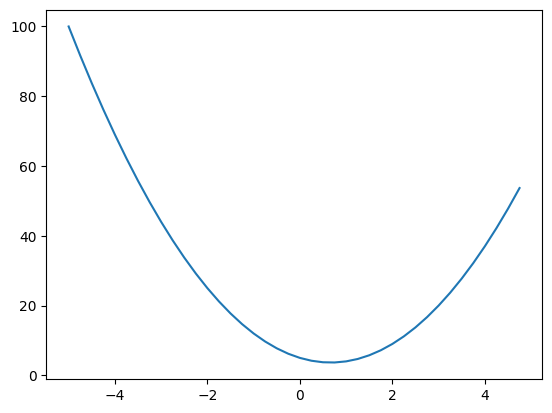

In [22]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [23]:
h = 0.000001
x = 2
(f(x + h) - f(x))/h

8.000003001384925

### Более сложный пример

In [24]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [25]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


https://pytorch.org/tutorials/beginner/examples_autograd/polynomial_custom_function.html

In [26]:
from torch.autograd import Function

In [27]:
class Exp(Function):
  """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """

  @staticmethod
  def forward(ctx, i):
    """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
    """
    result = i.exp()
    ctx.save_for_backward(result)
    return result

  @staticmethod
  def backward(ctx, grad_output):
    """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
    """
    print(ctx.saved_tensors)
    result, = ctx.saved_tensors
    return grad_output * result

In [28]:
# Use it by calling the apply method
input = torch.tensor(2.0, requires_grad=True)
output = Exp.apply(input)
output

tensor(7.3891, grad_fn=<ExpBackward>)

In [29]:
import math
math.exp(2.0)

7.38905609893065

In [30]:
output.backward()
show_tensor_params(output)
show_tensor_params(input)

(tensor(7.3891, grad_fn=<ExpBackward>),)
---
data - 7.389056205749512
grad - None
grad_fn - <torch.autograd.function.ExpBackward object at 0x7c2fcab0e440>
req_grad - True
is_leaf - False
---
data - 2.0
grad - 7.389056205749512
grad_fn - None
req_grad - True
is_leaf - True


<ipython-input-6-168b1ceafb31>:5: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  print(f"grad - {x.grad}")


**Задание**: реализуйте backward для Polynomial 0.5 * (5 * input ** 3 - 3 * input)

In [31]:
import torch


class Polynomial(torch.autograd.Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        return 0.5 * (5 * input ** 3 - 3 * input)

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        input, = ctx.saved_tensors
        return (7.5 * input ** 2 - 1.5) * grad_output

Практическое задание: написать собственный движок автоматического дифференцирования, а именно: реализовать

In [32]:
class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self.grad = 0
        # internal variables used for autograd graph construction
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op # the op that produced this node, for graphviz / debugging / etc

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out

    def softmax():
      exp_val =
      return out

    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

In [33]:
def test_sanity_check():

    x = Value(-4.0)
    z = 2 * x + 2 + x

    q = z.relu() + z * x
    h = (z * z).relu()
    y = h + q + q * x
    y.backward()
    xmg, ymg = x, y

    x = torch.Tensor([-4.0]).double()
    x.requires_grad = True
    z = 2 * x + 2 + x
    q = z.relu() + z * x
    h = (z * z).relu()
    y = h + q + q * x
    y.backward()
    xpt, ypt = x, y


    # forward pass went well
    assert ymg.data == ypt.data.item()
    # backward pass went well
    print(xmg, xpt, xpt.grad)
    assert xmg.grad == xpt.grad.item()


def test_more_ops():

    a = Value(-4.0)
    b = Value(2.0)
    c = a + b
    d = a * b + b**3
    c += c + 1
    c += 1 + c + (-a)
    d += d * 2 + (b + a).relu()
    d += 3 * d + (b - a).relu()
    e = c - d
    f = e**2
    g = f / 2.0
    g += 10.0 / f
    g.backward()
    amg, bmg, gmg = a, b, g

    a = torch.Tensor([-4.0]).double()
    b = torch.Tensor([2.0]).double()
    a.requires_grad = True
    b.requires_grad = True
    c = a + b
    d = a * b + b**3
    c = c + c + 1
    c = c + 1 + c + (-a)
    d = d + d * 2 + (b + a).relu()
    d = d + 3 * d + (b - a).relu()
    e = c - d
    f = e**2
    g = f / 2.0
    g = g + 10.0 / f
    g.backward()
    apt, bpt, gpt = a, b, g

    tol = 1e-6
    # forward pass went well
    assert abs(gmg.data - gpt.data.item()) < tol
    # backward pass went well
    assert abs(amg.grad - apt.grad.item()) < tol
    assert abs(bmg.grad - bpt.grad.item()) < tol

In [34]:
a = Value(-4.0)
b = Value(2.0)
d = Value(3.0)

In [35]:
c = a + b
e = c * d
e.backward()

In [36]:
test_sanity_check()

Value(data=-4.0, grad=46.0) tensor([-4.], dtype=torch.float64, requires_grad=True) tensor([46.], dtype=torch.float64)


In [37]:
test_more_ops()

# Обучение на основе собственной бибилотеки

## Многослойный перцептрон на основе класса Value

In [38]:
import random

class Module:

    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0

    def parameters(self):
        return []

class Neuron(Module):

    def __init__(self, nin, nonlin=True):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(0)
        self.nonlin = nonlin

    def __call__(self, x):
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        return act.relu() if self.nonlin else act

    def parameters(self):
        return self.w + [self.b]

    def __repr__(self):
        return f"{'ReLU' if self.nonlin else 'Linear'}Neuron({len(self.w)})"

class Layer(Module):

    def __init__(self, nin, nout, **kwargs):
        self.neurons = [Neuron(nin, **kwargs) for _ in range(nout)]

    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"

class MLP(Module):

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1], nonlin=i!=len(nouts)-1) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"

## Обучение многослойного перцептрона

Сам перцептрон

In [89]:
nn = MLP(3, [4, 4, 1])
print(nn)
print("number of parameters", len(nn.parameters()))

MLP of [Layer of [ReLUNeuron(3), ReLUNeuron(3), ReLUNeuron(3), ReLUNeuron(3)], Layer of [ReLUNeuron(4), ReLUNeuron(4), ReLUNeuron(4), ReLUNeuron(4)], Layer of [LinearNeuron(4)]]
number of parameters 41


Набор данных

In [88]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets


#https://wandb.ai/hchgssarwyh/polynom_learning_

In [90]:
def loss(batch_size=None):
    inputs = [list(map(Value, _)) for _ in xs]
    scores = list(map(nn, inputs))
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(ys, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))

    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in nn.parameters()))
    total_loss = data_loss + reg_loss

    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(ys, scores)]

    return total_loss, sum(accuracy) / len(accuracy)

In [93]:
for k in range(10):

    # forward
    total_loss, acc = loss()
    wandb.log({'total_loss':total_loss.data, 'acc':acc})
    # backward
    nn.zero_grad()
    total_loss.backward()

    # update (sgd)
    learning_rate = 1.0 - 0.9*k/100
    for p in nn.parameters():
        p.data -= learning_rate * p.grad

    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

step 0 loss 0.9245059666749308, accuracy 66.66666666666666%
step 1 loss 0.7989224080301561, accuracy 33.33333333333333%
step 2 loss 2.074504503197965, accuracy 66.66666666666666%
step 3 loss 0.22421668791026653, accuracy 100.0%
step 4 loss 0.001611319709800865, accuracy 100.0%
step 5 loss 0.0016106984448164845, accuracy 100.0%
step 6 loss 0.001610083216770455, accuracy 100.0%
step 7 loss 0.0016094740189167977, accuracy 100.0%
step 8 loss 0.0016088708445772394, accuracy 100.0%
step 9 loss 0.0016082736871410853, accuracy 100.0%


# Домашнее задание

**Домашнее задание 1.** Доделать практику. Оформить код в три отдельных модуля `autograd`, `nn`, `train`

**Домашнее задание 2 (Опционально).** Создать свою функцию softmax, наследуемую от `torch.autograd.Function` и имплементировать forward и backward проход. Сравнить со стандартной функцией в Pytorch.
[Создание функций](https://pytorch.org/tutorials/beginner/examples_autograd/two_layer_net_custom_function.html) [Софтмакс](https://congyuzhou.medium.com/softmax-3408fb42d55a)

In [55]:
class softmax(torch.autograd.Function):
    @staticmethod
    def forward(ctx, values):
        exp_values = torch.exp(values)
        exp_values_sum = torch.sum(exp_values)
        result = exp_values/exp_values_sum
        ctx.save_for_backward(result)
        return result
    @staticmethod
    def backward(ctx, grad_output):

        r, = ctx.saved_tensors
        gr = torch.mul(r, -1*r+1)
        return grad_output * gr

In [78]:
input1 = torch.tensor([2.1, 2.0, 2.0, 8.8], requires_grad=True)
input2 = torch.tensor([2.1, 2.0, 2.0, 8.8], requires_grad=True)

In [79]:
from re import I
sm = torch.nn.Softmax(dim=0)
output1 = sm(input1)
output1

tensor([0.0012, 0.0011, 0.0011, 0.9966], grad_fn=<SoftmaxBackward0>)

In [81]:
output2 = softmax.apply(input2)
output2

tensor([0.0012, 0.0011, 0.0011, 0.9966], grad_fn=<softmaxBackward>)

In [80]:
output1.sum().backward()
show_tensor_params(input1)

---
data - tensor([2.1000, 2.0000, 2.0000, 8.8000])
grad - tensor([7.3115e-11, 6.6157e-11, 6.6157e-11, 5.9399e-08])
grad_fn - None
req_grad - True
is_leaf - True


In [82]:
output2.sum().backward()
show_tensor_params(input2)

---
data - tensor([2.1000, 2.0000, 2.0000, 8.8000])
grad - tensor([0.0012, 0.0011, 0.0011, 0.0034])
grad_fn - None
req_grad - True
is_leaf - True


**Домашнее задание 3 (Продвинутая группа).** Добавить функцию софтмакс в собственну библиотеку автоматического дифференцирования. Сравнить с пунктом 2

In [ ]:
# Ваш код

**Домашнее задание 4 (Продвинутая группа).** Добавить визуализацию обучения. Потом мы пройдем более подробно.

https://docs.wandb.ai/guides/integrations/pytorch

https://docs.wandb.ai/ref/python/watch  

https://docs.wandb.ai/guides/track/jupyter

In [83]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.9/243.9 kB 20.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.7 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=2f0483cfb515bee2b44c0c360f8aef35b559bee2c728ad284f54f792801f5289
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [84]:
!wandb login 4b5e2a418d31bb23751d4996337e8c53d7b01883

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [85]:
import wandb
run = wandb.init(project="polynom_learning_")

wandb: Currently logged in as: hchgssarwyh. Use `wandb login --relogin` to force relogin


In [94]:
run.finish()

acc,▅▁▅███████
total_loss,▄▄█▂▁▁▁▁▁▁
acc,1.0
total_loss,0.00161
